In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model, model_selection, preprocessing, metrics
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
DSTrain = pd.read_csv("train.csv")
DSTest = pd.read_csv("test.csv")

In [4]:
#DSTrain.shape
DSTest.shape

(2947, 563)

In [5]:
DSTrain.duplicated().any()

False

In [6]:
print(DSTrain.isna().sum())
print("\n\nTotal NA values:", DSTrain.isna().sum().sum())

tBodyAcc-mean()-X       0
tBodyAcc-mean()-Y       0
tBodyAcc-mean()-Z       0
tBodyAcc-std()-X        0
tBodyAcc-std()-Y        0
                       ..
angle(X,gravityMean)    0
angle(Y,gravityMean)    0
angle(Z,gravityMean)    0
subject                 0
Activity                0
Length: 563, dtype: int64


Total NA values: 0


In [7]:
print(DSTrain["Activity"].value_counts(), "\n\n")
print(DSTest["Activity"].value_counts())

Activity
LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: count, dtype: int64 


Activity
LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: count, dtype: int64


In [9]:
activites = DSTrain["Activity"].unique()

class_map = {i : val for i, val in enumerate(activites)}
class_map_reverse = {key : val for val, key in class_map.items()}

print(class_map)

{0: 'STANDING', 1: 'SITTING', 2: 'LAYING', 3: 'WALKING', 4: 'WALKING_DOWNSTAIRS', 5: 'WALKING_UPSTAIRS'}


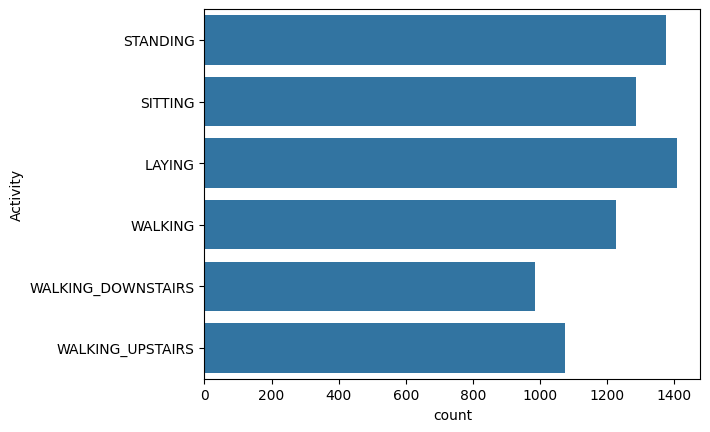

In [10]:
sns.countplot(DSTrain['Activity'])
plt.show()

In [11]:
data = pd.concat([DSTrain, DSTest], axis=0)
data.reset_index(drop = True, inplace = True)

data.isna().sum()

data.iloc[:, :-1].min().value_counts()

data.iloc[:, :-1].max().value_counts()

data.Activity.value_counts()

Activity
LAYING                1944
STANDING              1906
SITTING               1777
WALKING               1722
WALKING_UPSTAIRS      1544
WALKING_DOWNSTAIRS    1406
Name: count, dtype: int64

In [12]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Activity'] = le.fit_transform(data.Activity)
data['Activity'].sample(5)

1813     0
1229     0
525      2
10186    0
5984     3
Name: Activity, dtype: int32

In [13]:
# Calculate the correlation values
feature_cols = data.columns[:-1]
corr_values = data[feature_cols].corr()

# Simplify by emptying all the data below the diagonal
tril_index = np.tril_indices_from(corr_values)

# Make the unused values NaNs
for coord in zip(*tril_index):
    corr_values.iloc[coord[0], coord[1]] = np.NaN
    
# Stack the data and convert to a data frame
corr_values = (corr_values
               .stack()
               .to_frame()
               .reset_index()
               .rename(columns={'level_0':'feature1',
                                'level_1':'feature2',
                                0:'correlation'}))

# Get the absolute values for sorting
corr_values['abs_correlation'] = corr_values.correlation.abs()

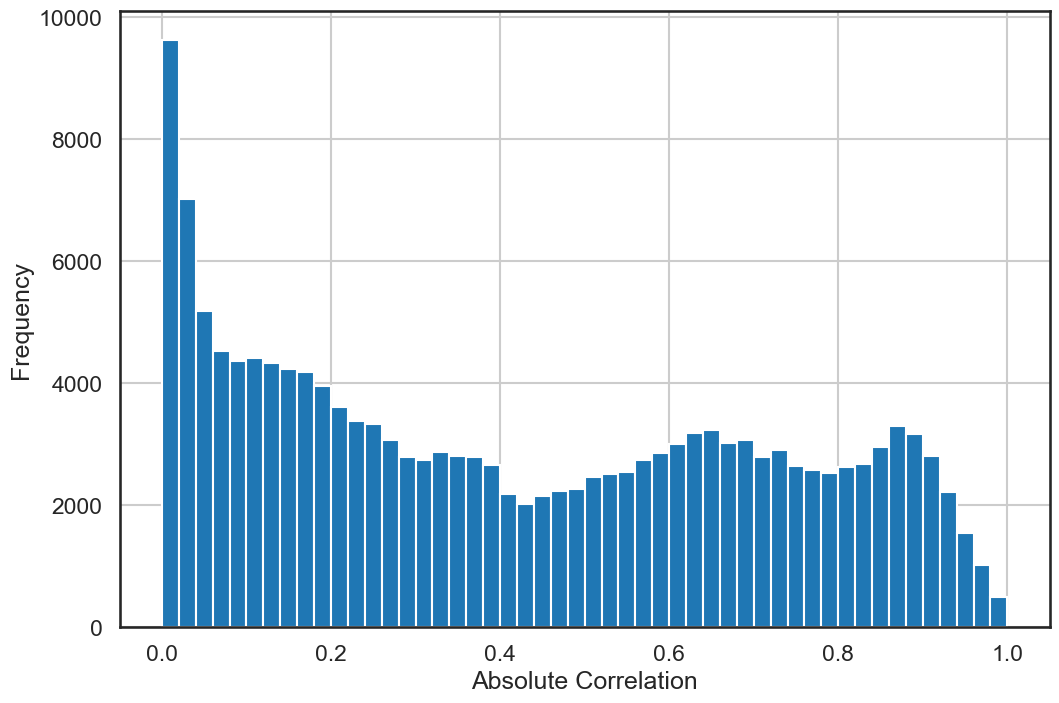

In [14]:
sns.set_context('talk')
sns.set_style('white')

ax = corr_values.abs_correlation.hist(bins=50, figsize=(12, 8))
ax.set(xlabel='Absolute Correlation', ylabel='Frequency');

In [15]:
# The most highly correlated values
corr_values.sort_values('correlation', ascending=False).query('abs_correlation>0.8')

,feature1,feature2,correlation,abs_correlation
93392,tBodyAccMag-max(),tGravityAccMag-max(),1.000000,1.000000
93750,tBodyAccMag-min(),tGravityAccMag-min(),1.000000,1.000000
157435,fBodyBodyGyroJerkMag-mean(),fBodyBodyGyroJerkMag-sma(),1.000000,1.000000
157084,fBodyBodyGyroMag-mean(),fBodyBodyGyroMag-sma(),1.000000,1.000000
96228,tBodyAccMag-arCoeff()3,tGravityAccMag-arCoeff()3,1.000000,1.000000
...,...,...,...,...
22698,tGravityAcc-mean()-Y,"angle(Y,gravityMean)",-0.993425,0.993425
39300,"tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4",-0.994267,0.994267
38813,"tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3",-0.994628,0.994628
23218,tGravityAcc-mean()-Z,"angle(Z,gravityMean)",-0.994764,0.994764


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

# Get the split indexes
strat_shuf_split = StratifiedShuffleSplit(n_splits=1, 
                                          test_size=0.3, 
                                          random_state=42)

train_idx, test_idx = next(strat_shuf_split.split(data[feature_cols], data.Activity))

# Create the dataframes
X_train = data.loc[train_idx, feature_cols]
y_train = data.loc[train_idx, 'Activity']

X_test  = data.loc[test_idx, feature_cols]
y_test  = data.loc[test_idx, 'Activity']

In [17]:
y_train.value_counts(normalize=True)

Activity
0    0.188792
2    0.185046
1    0.172562
3    0.167152
5    0.149951
4    0.136496
Name: proportion, dtype: float64

In [18]:
y_test.value_counts(normalize=True)

Activity
0    0.188673
2    0.185113
1    0.172492
3    0.167314
5    0.149838
4    0.136570
Name: proportion, dtype: float64

In [19]:
from sklearn.linear_model import LogisticRegression

# Standard logistic regression
lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)

In [20]:
from sklearn.linear_model import LogisticRegressionCV

# L1 regularized logistic regression
lr_l1 = LogisticRegressionCV(Cs=10, cv=4, penalty='l1', solver='liblinear').fit(X_train, y_train)

In [21]:
# L2 regularized logistic regression
lr_l2 = LogisticRegressionCV(Cs=10, cv=4, penalty='l2', solver='liblinear').fit(X_train, y_train)

In [23]:
coefficients = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    coeffs = mod.coef_
    coeff_label = pd.MultiIndex(levels=[[lab], [0,1,2,3,4,5]], 
                                 codes=[[0,0,0,0,0,0], [0,1,2,3,4,5]])
    coefficients.append(pd.DataFrame(coeffs.T, columns=coeff_label))

coefficients = pd.concat(coefficients, axis=1)

coefficients.sample(10)

lr                                                          l1  \
            0         1         2         3         4         5         0   
467 -0.000523  0.216454  0.308929  0.066086  0.104924  0.206312 -0.004432   
456 -0.059239  0.039870 -0.370828  0.197846 -0.556560  0.509676  0.000000   
82  -0.016651 -0.302698  0.320556  0.046025  0.126602 -0.333869  0.000000   
261 -0.034232  0.035707 -0.124384 -0.803902  0.132501  0.393551  0.000000   
378 -0.085439 -0.158880  0.479389  0.760207 -0.064398 -0.063732  0.000000   
14   0.032498  0.499257 -0.193457 -0.011722 -0.375586 -0.282184  0.000000   
311 -0.024237  0.133335 -0.005122 -0.025590  0.084049 -0.205362  0.000000   
101 -0.032113  0.127545 -0.293404  0.170825  0.185993 -0.522840  0.000000   
400 -0.022038  0.132983  0.028226  0.196753  0.152301  0.002795  0.000000   
346 -0.031886  0.037701 -0.278553 -0.023813  0.316430 -0.555240  0.000000   

                                                             l2            \
            1         2         3         4         5         0         1   
467  0.339955  0.431617  0.000000  0.095832  0.114816 -0.011997  0.523692   
456  0.000000 -0.011718  0.000000 -1.752102  1.725931 -0.117348 -0.592430   
82  -1.286244  1.397925  0.000000  0.000000 -0.031383 -0.019313 -1.251881   
261  0.000000 -0.233081 -1.373943  0.000000  0.163227 -0.038741  1.368772   
378  0.000000  0.508609  0.929497  0.000000  0.039401 -0.162858 -2.482238   
14   1.486946  0.000000  0.000000 -1.185324 -0.018121  0.036641  2.515332   
311  0.000000  0.000000  0.000000  0.146538 -0.331534 -0.049434  0.433723   
101  0.000000  0.000000  0.000000  0.114236 -0.516388 -0.048000  0.662487   
400  0.000000  0.000000  0.000393  0.210953 -0.001785 -0.044923  0.156150   
346  0.000000  0.000000  0.000000  0.691080 -0.519542 -0.047979  0.473656   

                                             
            2         3         4         5  
467  0.914334  0.002138  0.308408  0.186508  
456  0.415338  0.257346 -0.858735  0.715395  
82   2.322577  0.081824  0.347317 -0.481404  
261 -1.757654 -1.671581  0.282158  0.758349  
378  2.748224  1.283896  0.075907  0.070184  
14  -1.512788 -0.067439 -0.742954 -0.645543  
311 -0.048251  0.097940  0.290332 -0.438534  
101 -1.058936  0.313077  0.403755 -1.125568  
400 -0.010519  0.448848  0.258597  0.032217  
346 -1.172581 -0.134214  0.620626 -1.168775

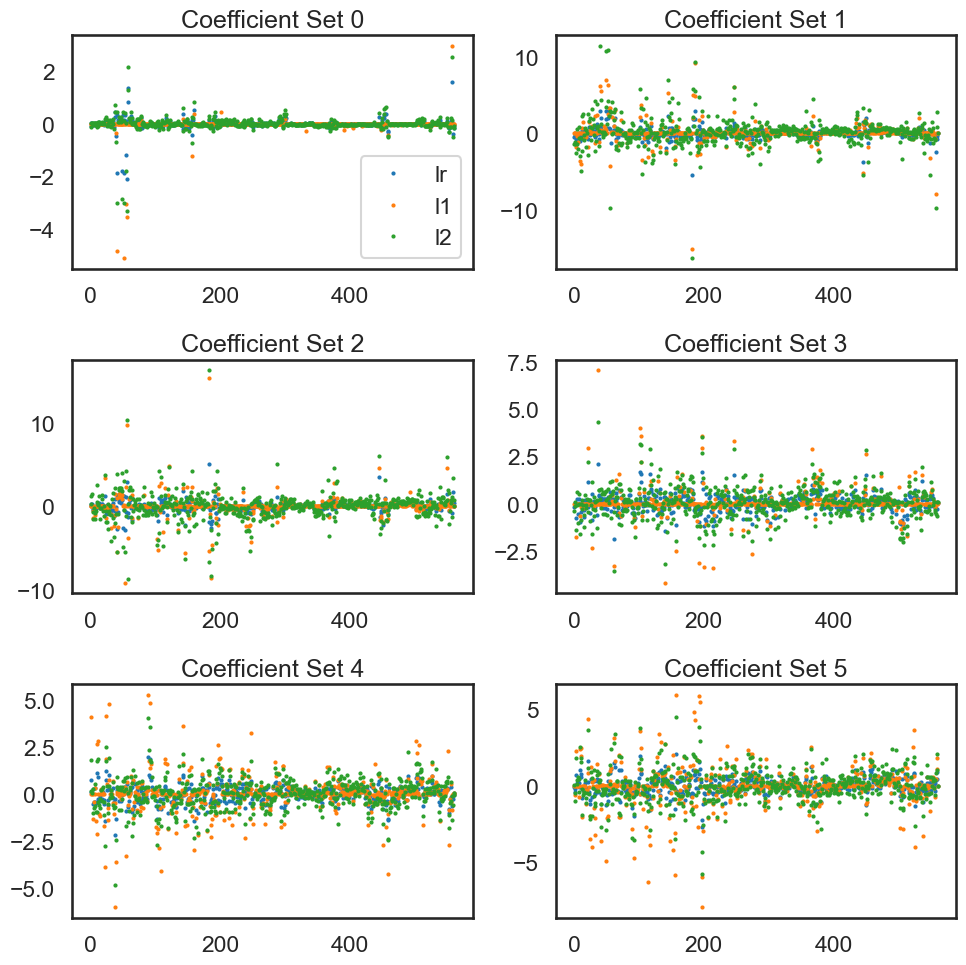

In [24]:
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(10,10)

for ax in enumerate(axList):
    loc = ax[0]
    ax = ax[1]
    
    data = coefficients.xs(loc, level=1, axis=1)
    data.plot(marker='o', ls='', ms=2.0, ax=ax, legend=False)
    
    if ax is axList[0]:
        ax.legend(loc=4)
        
    ax.set(title='Coefficient Set '+str(loc))

plt.tight_layout()

In [25]:
# Predict the class and the probability for each
y_pred = list()
y_prob = list()

coeff_labels = ['lr', 'l1', 'l2']
coeff_models = [lr, lr_l1, lr_l2]

for lab,mod in zip(coeff_labels, coeff_models):
    y_pred.append(pd.Series(mod.predict(X_test), name=lab))
    y_prob.append(pd.Series(mod.predict_proba(X_test).max(axis=1), name=lab))
    
y_pred = pd.concat(y_pred, axis=1)
y_prob = pd.concat(y_prob, axis=1)

y_pred.head()

,lr,l1,l2
0,3,3,3
1,5,5,5
2,3,3,3
3,1,1,1
4,0,0,0


In [26]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize

metrics = list()
cm = dict()

for lab in coeff_labels:

    # Preciision, recall, f-score from the multi-class support function
    precision, recall, fscore, _ = score(y_test, y_pred[lab], average='weighted')
    
    # The usual way to calculate accuracy
    accuracy = accuracy_score(y_test, y_pred[lab])
    
    # ROC-AUC scores can be calculated by binarizing the data
    auc = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
              label_binarize(y_pred[lab], classes=[0,1,2,3,4,5]), 
              average='weighted')
    

# Last, the confusion matrix
    cm[lab] = confusion_matrix(y_test, y_pred[lab])
    
    metrics.append(pd.Series({'precision':precision, 'recall':recall, 
                              'fscore':fscore, 'accuracy':accuracy,
                              'auc':auc}, 
                             name=lab))

metrics = pd.concat(metrics, axis=1)

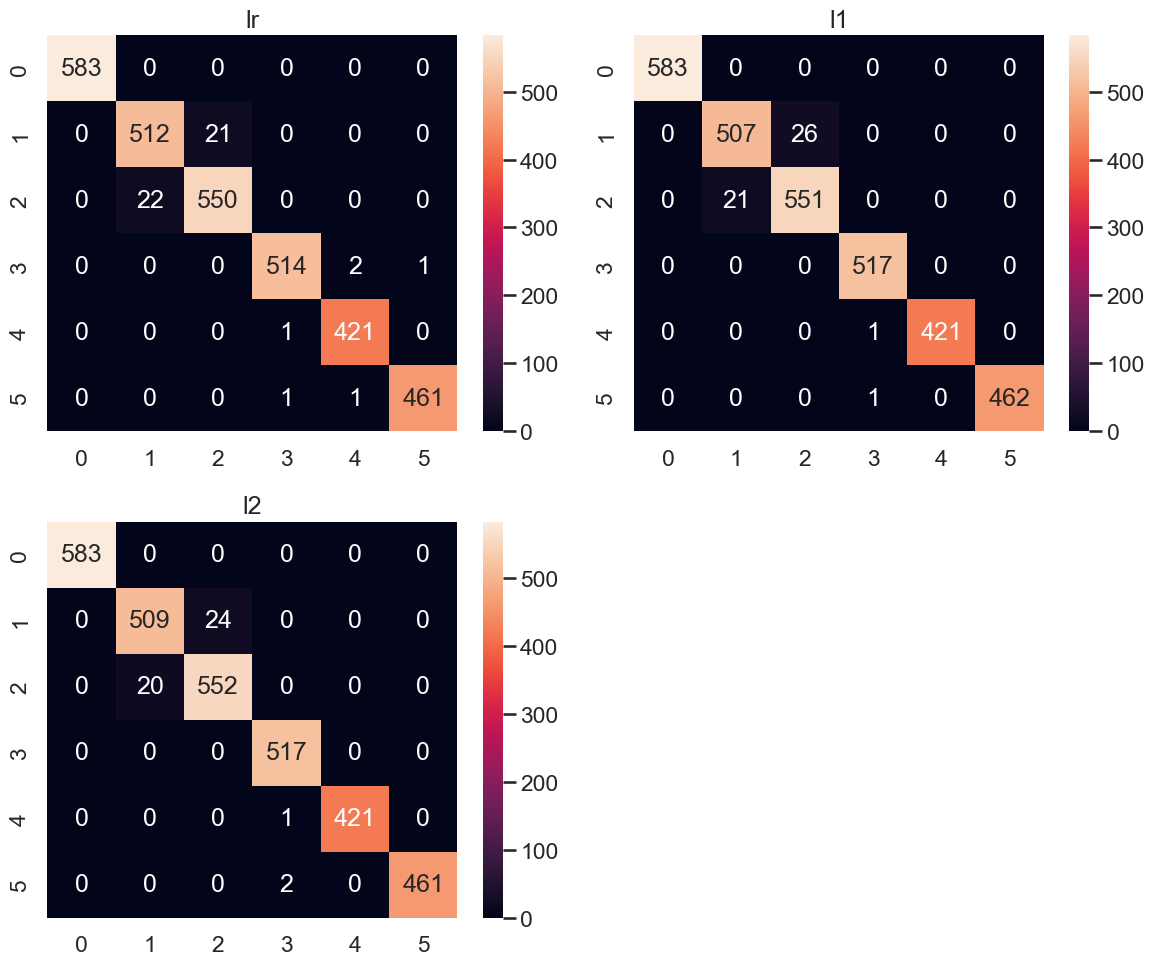

In [27]:
fig, axList = plt.subplots(nrows=2, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 10)

axList[-1].axis('off')

for ax,lab in zip(axList[:-1], coeff_labels):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d');
    ax.set(title=lab);
    
plt.tight_layout()

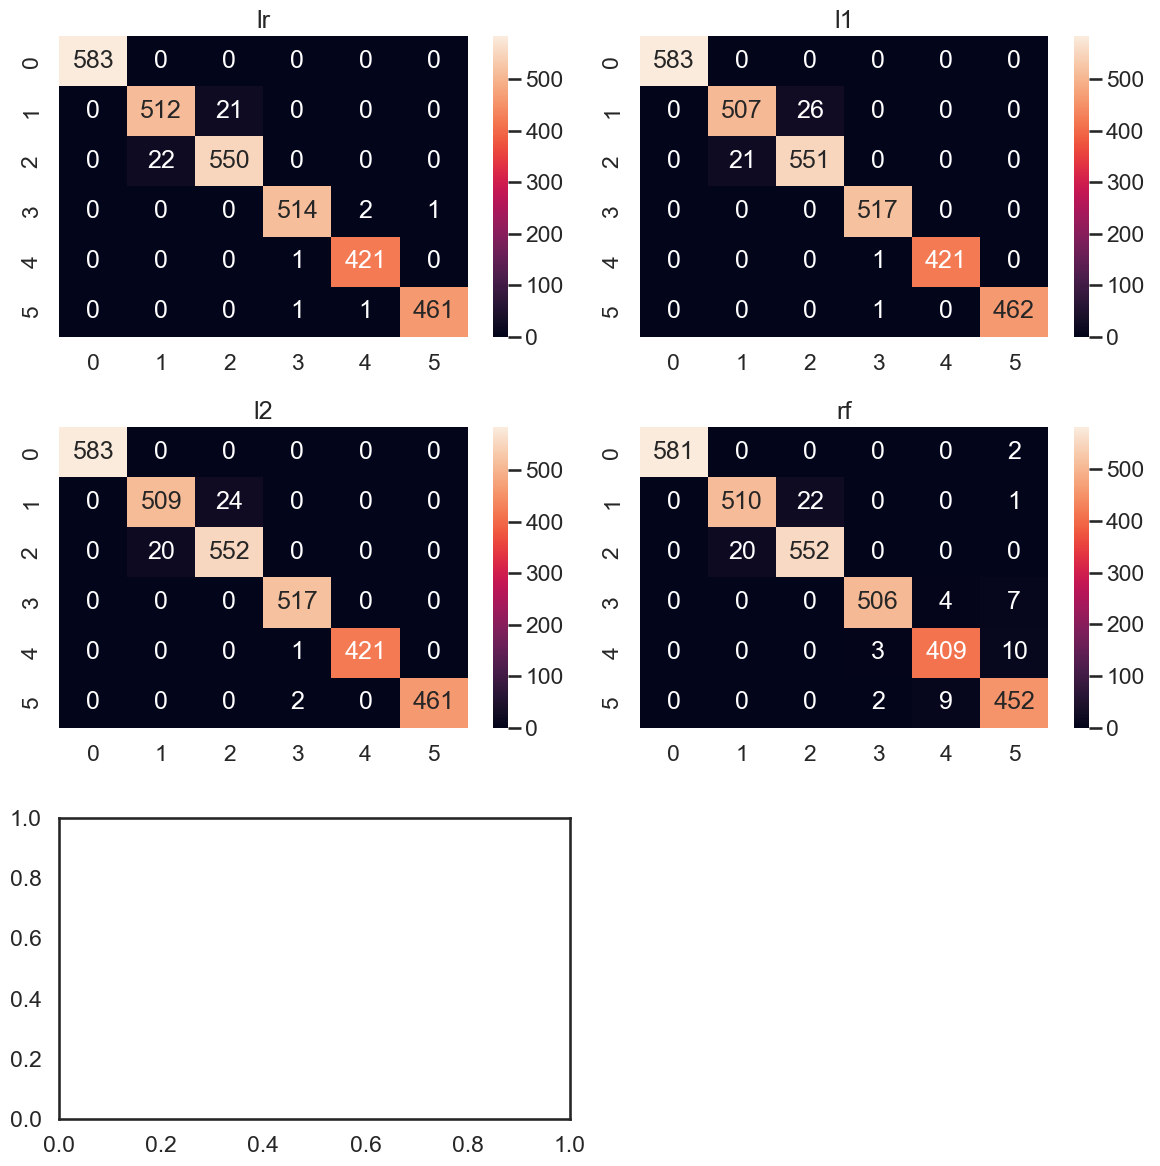

In [28]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=None, class_weight='balanced').fit(X_train, y_train)

# %% Evaluate Random Forest Model
# Predict class labels and probabilities
y_pred_rf = pd.Series(rf.predict(X_test), name='rf')
y_prob_rf = pd.Series(rf.predict_proba(X_test).max(axis=1), name='rf')

# Add predictions to existing DataFrames
y_pred = pd.concat([y_pred, y_pred_rf], axis=1)
y_prob = pd.concat([y_prob, y_prob_rf], axis=1)

# %% Metrics and Confusion Matrix for Random Forest
# Calculate metrics
precision_rf, recall_rf, fscore_rf, _ = score(y_test, y_pred_rf, average='weighted')
accuracy_rf = accuracy_score(y_test, y_pred_rf)
auc_rf = roc_auc_score(label_binarize(y_test, classes=[0,1,2,3,4,5]),
                       label_binarize(y_pred_rf, classes=[0,1,2,3,4,5]),
                       average='weighted')

# Confusion matrix
cm['rf'] = confusion_matrix(y_test, y_pred_rf)

# Add Random Forest metrics to the DataFrame
metrics['rf'] = pd.Series({'precision': precision_rf, 'recall': recall_rf,
                           'fscore': fscore_rf, 'accuracy': accuracy_rf,
                           'auc': auc_rf})

# %% Plot Confusion Matrix for Random Forest
fig, axList = plt.subplots(nrows=3, ncols=2)
axList = axList.flatten()
fig.set_size_inches(12, 12)

# Add an empty subplot for layout alignment if needed
axList[-1].axis('off')

# Plot all confusion matrices, including Random Forest
for ax, lab in zip(axList[:-1], coeff_labels + ['rf']):
    sns.heatmap(cm[lab], ax=ax, annot=True, fmt='d')
    ax.set(title=lab)

plt.tight_layout()

In [9]:
DSTrain["Activity"] = DSTrain["Activity"].apply(lambda x : class_map_reverse[x])
DSTest["Activity"] = DSTest["Activity"].apply(lambda x : class_map_reverse[x])

In [10]:
DSTrain.drop("subject", axis = 1, inplace = True)
DSTest.drop("subject", axis = 1, inplace = True)

In [11]:
time_steps = 10

def create_sequences(X, y, time_steps = 5):
    X_, y_ = [], []
    n = X.shape[0]
    for i in np.arange(n - time_steps):
        X_.append(X[i:(i + time_steps)])
        y_.append(y[i + time_steps])
    return np.array(X_), np.array(y_)

X_train_ = DSTrain.drop("Activity", axis = 1).values
X_test_ = DSTest.drop("Activity", axis = 1).values
y_train_ = DSTrain["Activity"].values
y_test_ = DSTest["Activity"].values

X_train, y_train = create_sequences(X_train_, y_train_, time_steps)
X_test, y_test = create_sequences(X_test_, y_test_, time_steps)

print(X_train.shape, X_test.shape)

(7342, 10, 561) (2937, 10, 561)


In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape = X_train.shape[1:]),
    tf.keras.layers.LSTM(units = 256, return_sequences = True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(units = 128, return_sequences = True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(units = 64),
    tf.keras.layers.Dense(units = 32, activation = "relu"),
    tf.keras.layers.Dense(units = len(class_map), activation = "softmax")
])

model.compile(optimizer = tf.keras.optimizers.Adam(0.005), loss = tf.keras.losses.SparseCategoricalCrossentropy(), metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 256)           837632    
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           197120    
                                                                 
 dropout_1 (Dropout)         (None, 10, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 6)                 1

In [13]:
cb = tf.keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.3, callbacks = cb)

Epoch 1/100
161/161 [==============================] - 16s 60ms/step - loss: 1.0633 - accuracy: 0.4647 - val_loss: 0.9829 - val_accuracy: 0.5270
Epoch 2/100
161/161 [==============================] - 8s 49ms/step - loss: 0.6680 - accuracy: 0.6902 - val_loss: 0.5710 - val_accuracy: 0.7712
Epoch 3/100
161/161 [==============================] - 7s 46ms/step - loss: 0.4500 - accuracy: 0.8107 - val_loss: 0.4312 - val_accuracy: 0.7994
Epoch 4/100
161/161 [==============================] - 7s 46ms/step - loss: 0.4206 - accuracy: 0.8309 - val_loss: 0.5529 - val_accuracy: 0.7721
Epoch 5/100
161/161 [==============================] - 10s 61ms/step - loss: 0.3738 - accuracy: 0.8564 - val_loss: 0.5142 - val_accuracy: 0.7771
Epoch 6/100
161/161 [==============================] - 14s 88ms/step - loss: 0.3324 - accuracy: 0.8834 - val_loss: 0.3607 - val_accuracy: 0.8951
Epoch 7/100
161/161 [==============================] - 15s 91ms/step - loss: 0.3445 - accuracy: 0.8836 - val_loss: 0.4506 - val_accur

In [14]:
import matplotlib.pyplot as plt

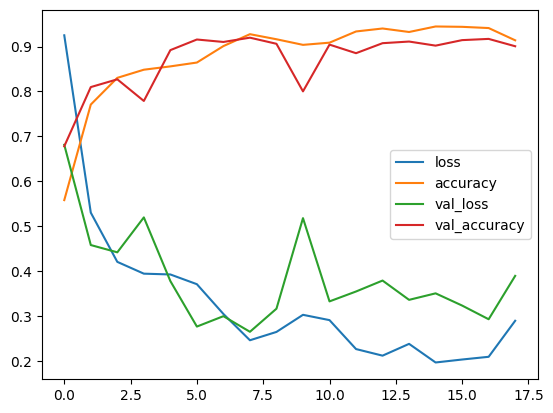

In [56]:
history_df = pd.DataFrame(history.history)
history_df.plot()
plt.show()

In [10]:
x = DSTrain.drop('Activity', axis = 1)
y = DSTrain['Activity']

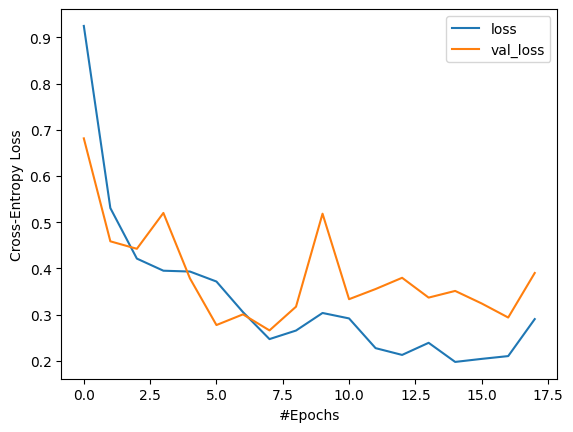

In [57]:
history_df[["loss", "val_loss"]].plot()
plt.xlabel("#Epochs")
plt.ylabel("Cross-Entropy Loss")
plt.show()

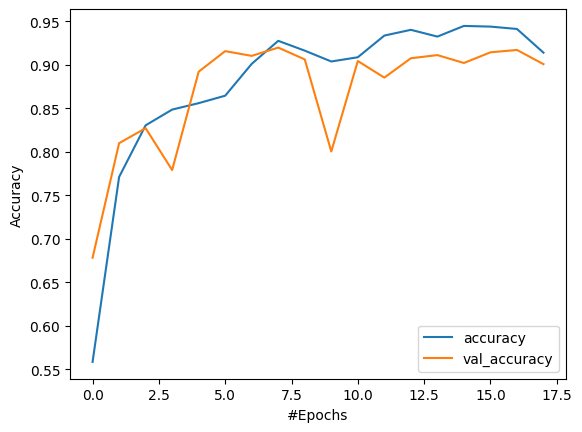

In [58]:
history_df[["accuracy", "val_accuracy"]].plot()
plt.xlabel("#Epochs")
plt.ylabel("Accuracy")
plt.show()

In [59]:
model.evaluate(X_test, y_test)

92/92 [==============================] - 1s 14ms/step - loss: 0.3382 - accuracy: 0.8989


[0.3382129371166229, 0.898876428604126]

In [60]:
y_test_pred_probs = model.predict(X_test)
y_test_pred = np.array([np.argmax(probs) for probs in y_test_pred_probs])

92/92 [==============================] - 3s 16ms/step


In [61]:
clf_report = metrics.classification_report(y_test, y_test_pred, digits = 4)
print(clf_report)

              precision    recall  f1-score   support

           0     0.9165    0.9253    0.9209       522
           1     0.8713    0.9104    0.8904       491
           2     0.9667    0.9181    0.9417       537
           3     0.8897    0.9597    0.9234       496
           4     0.8356    0.8595    0.8474       420
           5     0.9048    0.8068    0.8530       471

    accuracy                         0.8989      2937
   macro avg     0.8974    0.8966    0.8961      2937
weighted avg     0.9002    0.8989    0.8986      2937



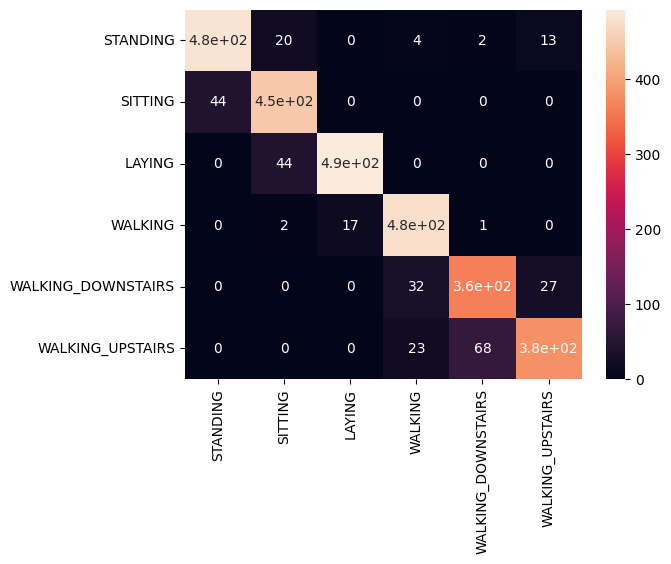

In [62]:
conf_matrix = metrics.confusion_matrix(y_test, y_test_pred)

sns.heatmap(conf_matrix, annot = True, xticklabels = class_map.values(), yticklabels = class_map.values())
plt.show()

In [11]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
yFit = LE.fit_transform(y)

In [12]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [14]:
LR = LogisticRegression()
LR.fit(x_train,y_train)

C:\Users\RBTGL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [15]:
yPred1 = LR.predict(x_test)
accuracy_score(y_test,yPred1)

0.9762066621346023

In [8]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(x_train,y_train)

NameError: name 'x_train' is not defined

In [17]:
yPred2 = RF.predict(x_test)
accuracy_score(y_test,yPred2)

0.9809653297076818

In [18]:
from sklearn.feature_selection import SelectKBest,f_classif

In [19]:
k = 200
selector = SelectKBest(f_classif,k=k)
x_train_selected = selector.fit_transform(x_train,y_train)
x_test_selected = selector.transform(x_test)

selected_indices = selector.get_support(indices = True)
selected_features = x_train.columns[selected_indices]
print(selected_features)

Index(['tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z',
       'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z',
       'tBodyAcc-max()-X', 'tBodyAcc-max()-Y', 'tBodyAcc-max()-Z',
       'tBodyAcc-min()-X',
       ...
       'fBodyBodyGyroMag-std()', 'fBodyBodyGyroMag-mad()',
       'fBodyBodyGyroMag-sma()', 'fBodyBodyGyroMag-iqr()',
       'fBodyBodyGyroMag-entropy()', 'fBodyBodyGyroJerkMag-mean()',
       'fBodyBodyGyroJerkMag-sma()', 'fBodyBodyGyroJerkMag-entropy()',
       'angle(X,gravityMean)', 'angle(Y,gravityMean)'],
      dtype='object', length=200)


In [20]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

In [21]:
estimator = RandomForestClassifier()

In [22]:
k = 100
rfe_selector = RFE(estimator, n_features_to_select = k)
x_train_selected_rfe = rfe_selector.fit_transform(x_train_selected,y_train)
x_test_selected_rfe = rfe_selector.transform(x_test_selected)

selected_indices_rfe = rfe_selector.get_support(indices = True)
selected_features_rfe = selected_features[selected_indices_rfe]
print(selected_features_rfe)

Index(['tBodyAcc-std()-X', 'tBodyAcc-mad()-X', 'tBodyAcc-max()-X',
       'tBodyAcc-energy()-X', 'tBodyAcc-entropy()-X', 'tGravityAcc-mean()-X',
       'tGravityAcc-mean()-Y', 'tGravityAcc-max()-X', 'tGravityAcc-max()-Y',
       'tGravityAcc-min()-X', 'tGravityAcc-min()-Y', 'tGravityAcc-energy()-X',
       'tBodyAccJerk-std()-X', 'tBodyAccJerk-std()-Y', 'tBodyAccJerk-std()-Z',
       'tBodyAccJerk-mad()-X', 'tBodyAccJerk-mad()-Y', 'tBodyAccJerk-mad()-Z',
       'tBodyAccJerk-max()-X', 'tBodyAccJerk-max()-Y', 'tBodyAccJerk-max()-Z',
       'tBodyAccJerk-sma()', 'tBodyAccJerk-energy()-X', 'tBodyAccJerk-iqr()-X',
       'tBodyAccJerk-entropy()-X', 'tBodyAccJerk-entropy()-Z',
       'tBodyGyro-std()-X', 'tBodyGyro-std()-Y', 'tBodyGyro-std()-Z',
       'tBodyGyro-mad()-X', 'tBodyGyro-mad()-Y', 'tBodyGyro-mad()-Z',
       'tBodyGyro-min()-X', 'tBodyGyro-iqr()-X', 'tBodyGyro-iqr()-Y',
       'tBodyGyro-iqr()-Z', 'tBodyGyroJerk-std()-X', 'tBodyGyroJerk-std()-Z',
       'tBodyGyroJerk-mad()-X',

In [19]:
print(len(selected_features_rfe))

100


In [20]:
RF2 = RandomForestClassifier()
RF2.fit(x_train_selected_rfe,y_train)

RandomForestClassifier()

In [21]:
y_pred_rfe = RF2.predict(x_test_selected_rfe)
from sklearn.metrics import accuracy_score

In [22]:
accuracy_score(y_test,y_pred_rfe)

0.9741672331747111

In [23]:
import joblib

In [24]:
joblib.dump(RF,"model_rfe")

['model_rfe']

In [25]:
joblib.dump(selector,"k_best_selector")

['k_best_selector']

In [26]:
joblib.dump(rfe_selector,"rfe_selector")

['rfe_selector']

In [27]:
DSTest.drop("Activity", axis = 1)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject
0,0.257178,-0.023285,-0.014654,-0.938404,-0.920091,-0.667683,-0.952501,-0.925249,-0.674302,-0.894088,...,-0.330370,-0.705974,0.006462,0.162920,-0.825886,0.271151,-0.720009,0.276801,-0.057978,2
1,0.286027,-0.013163,-0.119083,-0.975415,-0.967458,-0.944958,-0.986799,-0.968401,-0.945823,-0.894088,...,-0.121845,-0.594944,-0.083495,0.017500,-0.434375,0.920593,-0.698091,0.281343,-0.083898,2
2,0.275485,-0.026050,-0.118152,-0.993819,-0.969926,-0.962748,-0.994403,-0.970735,-0.963483,-0.939260,...,-0.190422,-0.640736,-0.034956,0.202302,0.064103,0.145068,-0.702771,0.280083,-0.079346,2
3,0.270298,-0.032614,-0.117520,-0.994743,-0.973268,-0.967091,-0.995274,-0.974471,-0.968897,-0.938610,...,-0.344418,-0.736124,-0.017067,0.154438,0.340134,0.296407,-0.698954,0.284114,-0.077108,2
4,0.274833,-0.027848,-0.129527,-0.993852,-0.967445,-0.978295,-0.994111,-0.965953,-0.977346,-0.938610,...,-0.534685,-0.846595,-0.002223,-0.040046,0.736715,-0.118545,-0.692245,0.290722,-0.073857,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2942,0.310155,-0.053391,-0.099109,-0.287866,-0.140589,-0.215088,-0.356083,-0.148775,-0.232057,0.185361,...,-0.376278,-0.750809,-0.337422,0.346295,0.884904,-0.698885,-0.651732,0.274627,0.184784,24
2943,0.363385,-0.039214,-0.105915,-0.305388,0.028148,-0.196373,-0.373540,-0.030036,-0.270237,0.185361,...,-0.320418,-0.700274,-0.736701,-0.372889,-0.657421,0.322549,-0.655181,0.273578,0.182412,24
2944,0.349966,0.030077,-0.115788,-0.329638,-0.042143,-0.250181,-0.388017,-0.133257,-0.347029,0.007471,...,-0.118854,-0.467179,-0.181560,0.088574,0.696663,0.363139,-0.655357,0.274479,0.181184,24
2945,0.237594,0.018467,-0.096499,-0.323114,-0.229775,-0.207574,-0.392380,-0.279610,-0.289477,0.007471,...,-0.205445,-0.617737,0.444558,-0.819188,0.929294,-0.008398,-0.659719,0.264782,0.187563,24


In [28]:
duplicated_columns = DSTest.columns[DSTest.T.duplicated()].to_list()

In [29]:
DSTest = DSTest.drop(duplicated_columns, axis = 1)

In [39]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, yPred2)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[280   0   0   0   0   0]
 [  0 250  12   0   0   0]
 [  0   9 267   0   0   0]
 [  0   0   0 243   2   2]
 [  0   0   0   0 204   2]
 [  0   0   0   0   1 199]]
